# Анализ программы лояльности

**Материалы:**   
[Презентация](<https://disk.yandex.ru/i/neaeu1PPFTBTNQ>)   
[Дашборд](<https://public.tableau.com/app/profile/valeria.shakulia/viz/_16866752114830/Dashboard1?publish=yes>)

В нашем распоряжении данные о покупках в магазине строительных материалов «Строили, строили и наконец построили». Все покупатели могут получить персональные карты и за 200 рублей в месяц могут стать участниками программы лояльности. В программу включены скидки, специальные предложения, подарки. Также покупатели могут приобрести товары без использования персональных карт.

**Цель:**   

Определить по анализу данных показывает ли внедренная программа лояльности ожидаемый рост ключевых метрик и стоит ли ее использовать дальше.

**Задачи:** 

- Провести исследовательский анализ данных
- Получить основные ритейл-метрики по когортам у клиентов внутри программы лояльности и вне ее
- Проанализировать насколько сработала текущая программа лояльности
- Сформулировать и проверить статистические гипотезы.

**Описание данных:**

Файл retail_dataset.csv:

- `purchaseId` — id чека;
- `item_ID` — id товара;
- `purchasedate` — дата покупки;
- `Quantity` — количество товара;
- `CustomerID` — id покупателя;
- `ShopID` — id магазина;
- `loyalty_program` — участвует ли покупатель в программе лояльности;

Файл product_codes.csv:

- `productID` — id товара;
- `price_per_one` — стоимость одной единицы товара;


**Оглавление**

1. [Изучение общей информации](#start)  
2. [Предобработка данных](#pre)  
3. [Исследовательский анализ данных](#quantity)
    * [Анализ количества товаров в чеке](#analysis)
    * [Распределение покупок за весь период](#purchases)
    * [Распределение покупок по магазинам](#purchaseshop)
    * [Распределение количества товаров в чеке по магазинам](#quantityshop)
    * [Распределение покупателей и участников программы лояльности по магазинам](#customershop)   
4. [Анализ программы лояльности](#loyalty)
    * [Анализ покупателей](#loyaltycustomer)
    * [Анализ покупок](#loyaltypurchase)
    * [Анализ среднего чека и LTV](#LTV)
5. [Статистический анализ данных](#stats)
    * [Гипотеза о средних чеках](#check)
    * [Гипотеза о количестве товара в чеке](#statsquantity)  
6. [Общий вывод и рекомендации](#rec)

<a id="start"></a>
## Изучение общей информации  

Загружаем данные о покупках в магазине строительных материалов из CSV-файлов в переменные.   


In [1]:
import pandas as pd
import datetime as dt
from datetime import timedelta
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import scipy.stats as stats
from functools import reduce 
import plotly.express as px
from itertools import cycle
from plotly import graph_objects as go
import math as mth

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', None)

In [2]:
# загружаем библиотеку, настроим вывод в формате "png" по деффолту для отображения на GitHub 
import plotly.io as pio 
pio.renderers.default = "png" 
svg_renderer = pio.renderers["png"] 
svg_renderer.scale = 1.2

In [3]:
# загруженние данных
path = '/datasets/'
purchase = pd.read_csv(path + 'retail_dataset.csv')
products = pd.read_csv(path + 'product_codes.csv')

In [4]:
# напишем функцию для полного описания данных
def total_describe(data):
    data_head = data.head(10)
    data_info = data.info()
    data_isna = pd.DataFrame(data.isna().sum())
    data_isna.columns = ['count_miss']
    display(data_info)
    print('Первые деять строк таблицы:')
    display(data_head)
    print('Информация о пропусках в данных:')
    display(data_isna)
    print('Краткое описание для всех столбцов')
    display(data.describe(include='all'))
    print('Гистограммы для всех числовых столбцов')
    data.hist(figsize=(10, 7));

Выведем описание данных о покупках в магазине.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105335 entries, 0 to 105334
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   purchaseid       105335 non-null  object 
 1   item_ID          105335 non-null  object 
 2   Quantity         105335 non-null  int64  
 3   purchasedate     105335 non-null  object 
 4   CustomerID       69125 non-null   float64
 5   ShopID           105335 non-null  object 
 6   loyalty_program  105335 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 5.6+ MB


None

Первые деять строк таблицы:


,purchaseid,item_ID,Quantity,purchasedate,CustomerID,ShopID,loyalty_program
0,538280,21873,11,2016-12-10 12:50:00,18427.0,Shop 0,0.0
1,538862,22195,0,2016-12-14 14:11:00,22389.0,Shop 0,1.0
2,538855,21239,7,2016-12-14 13:50:00,22182.0,Shop 0,1.0
3,543543,22271,0,2017-02-09 15:33:00,23522.0,Shop 0,1.0
4,543812,79321,0,2017-02-13 14:40:00,23151.0,Shop 0,1.0
5,538379,22965,0,2016-12-12 11:26:00,22805.0,Shop 0,1.0
6,540468,22189,0,2017-01-07 13:55:00,NaN,Shop 0,0.0
7,541424,79321,1,2017-01-17 17:57:00,NaN,Shop 0,0.0
8,538883,22891,0,2016-12-14 15:56:00,NaN,Shop 0,0.0
9,539501,22372,0,2016-12-20 11:08:00,22764.0,Shop 0,1.0


Информация о пропусках в данных:


,count_miss
purchaseid,0
item_ID,0
Quantity,0
purchasedate,0
CustomerID,36210
ShopID,0
loyalty_program,0


Краткое описание для всех столбцов


,purchaseid,item_ID,Quantity,purchasedate,CustomerID,ShopID,loyalty_program
count,105335,105335,105335.000000,105335,69125.000000,105335,105335.000000
unique,4894,3159,NaN,4430,NaN,31,NaN
top,537434,85123A,NaN,2016-12-06 16:57:00,NaN,Shop 0,NaN
freq,675,565,NaN,675,NaN,97393,NaN
mean,NaN,NaN,7.821218,NaN,21019.302047,NaN,0.226345
std,NaN,NaN,327.946695,NaN,1765.444679,NaN,0.418467
min,NaN,NaN,-74216.000000,NaN,18025.000000,NaN,0.000000
25%,NaN,NaN,0.000000,NaN,19544.000000,NaN,0.000000
50%,NaN,NaN,2.000000,NaN,20990.000000,NaN,0.000000
75%,NaN,NaN,7.000000,NaN,22659.000000,NaN,0.000000


Гистограммы для всех числовых столбцов


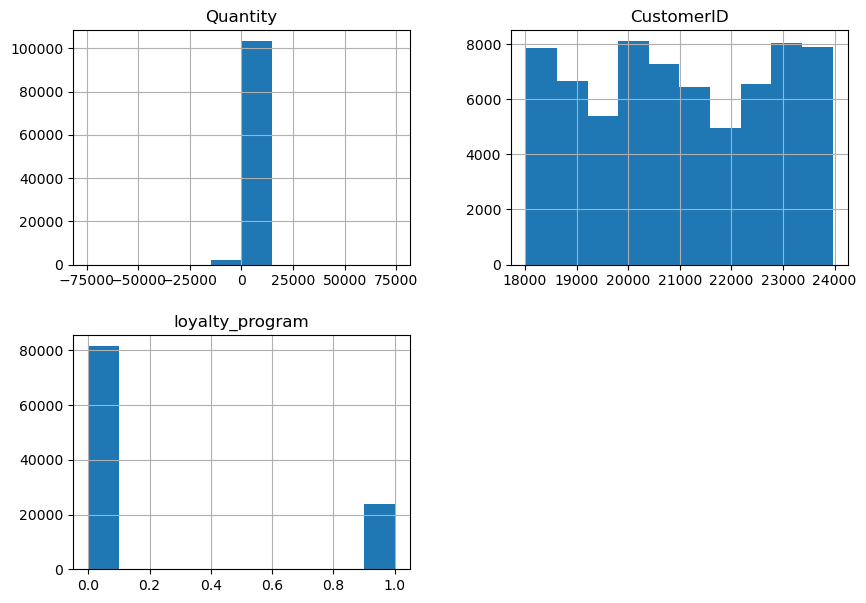

In [5]:
total_describe(purchase)

Выведем описание данных о стоимости товаров в магазине.

**Вывод:**  
Файл `retail_dataset.csv` содержит информацию о покупках в магазине строительных материалов.  
Всего в датасете 105335 записей и 7 столбцов.

* Столбцы `purchasedate`, `CustomerID` и `loyalty_program` имеют некорректный тип данных
* Пропуски присутствуют в столбце `CustomerID` 
* Наименования столбцов записаны некорректно
* По гистограмме и краткому описанию количества товаров в чеке можно заметить большой разброс от -74216 до 74214.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9969 entries, 0 to 9968
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   productID      9969 non-null   object 
 1   price_per_one  9969 non-null   float64
dtypes: float64(1), object(1)
memory usage: 155.9+ KB


None

Первые деять строк таблицы:


,productID,price_per_one
0,85123A,2.55
1,71053,3.39
2,84406B,2.75
3,84029G,3.39
4,84029E,3.39
5,22752,7.65
6,21730,4.25
7,22633,1.85
8,22632,1.85
9,84879,1.69


Информация о пропусках в данных:


,count_miss
productID,0
price_per_one,0


Краткое описание для всех столбцов


,productID,price_per_one
count,9969,9969.000000
unique,3159,NaN
top,DOT,NaN
freq,174,NaN
mean,NaN,19.503697
std,NaN,330.880754
min,NaN,0.000000
25%,NaN,1.250000
50%,NaN,2.550000
75%,NaN,5.510000


Гистограммы для всех числовых столбцов


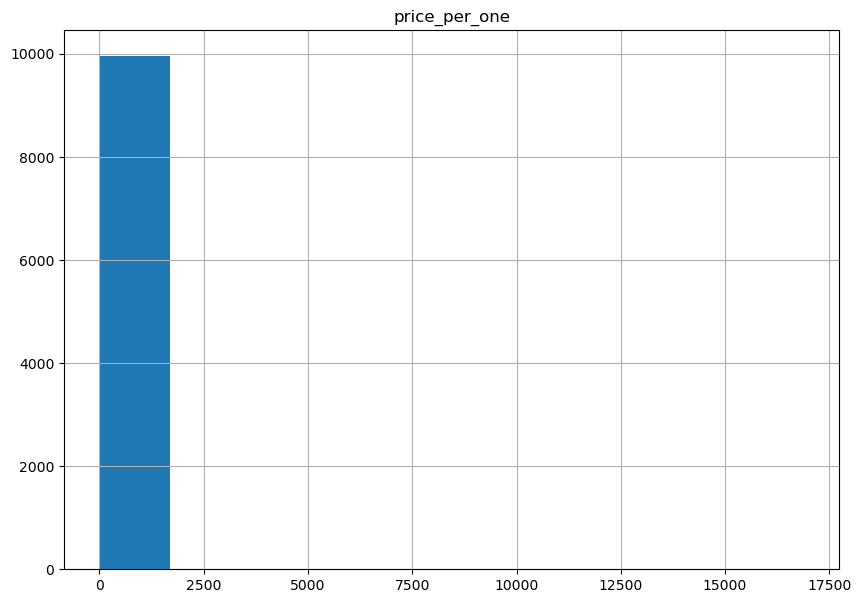

In [6]:
total_describe(products)

**Вывод:**  
Файл `product_codes.csv` содержит информацию о стоимости за единицу товара в магазине строительных материалов.  
Всего в датасете 9969 записей и 2 столбца.

* Пропуски отсутствуют 
* Наименования столбцов записаны некорректно
* По гистограмме и краткому описанию стоимости товара можно заметить большой разброс от 0 до 16888.

**Итог**

Необходимо:   

* Переименовать столбцы
* Заполнить по возможности пропуски в `CustomerID`
* Изменить типы данных в столбцах `purchasedate`, `CustomerID` и `loyalty_program`
* Также проверить данные на дубликаты
* Проверить на аномалии и выбросы столбцы `price_per_one` и `Quantity`.

<a id="pre"></a>
## Предобработка данных   

* **Переименование столбцов** 

In [7]:
# список датасетов
datasets = [purchase, products]

# приведем названия столбцов к нижнему регистру, добавим нижнее подчеркивание и выведем результат списоком
for data in datasets:
    data.columns = [col.lower().replace('id', '_id').replace('__', '_').replace('date', '_time') for col in data.columns]
    print(data.columns)

Index(['purchase_id', 'item_id', 'quantity', 'purchase_time', 'customer_id',
       'shop_id', 'loyalty_program'],
      dtype='object')
Index(['product_id', 'price_per_one'], dtype='object')


* **Изменение типа данных**  

Заменим типы данных в столбцах `purchase_date`, `customer_id` и `loyalty_program`.

In [8]:
# изменяем типы данных
purchase['purchase_time'] = pd.to_datetime(purchase['purchase_time'])
purchase['loyalty_program'] = purchase['loyalty_program'].astype('int64')
purchase['customer_id'] = purchase['customer_id'].apply(lambda x: str(x) if str(x) != 'nan' else None)

* **Замена пропусков**   

Ранее мы обнаружили в столбце `customer_id` 36210 пропущенных значений, что составляет около 30% всех данных.    
Проверим, есть ли среди пропущенных значений участники программы лояльности.

Пропуски у участников программы отсутствуют. Значит скорее всего это покупатели, которые не приобрели персональную карту или не предоставили ее на кассе. Поскольку удаление такого количества пропущенных значений может исказить результаты, заменим их на номера чеков. 

In [9]:
# заранее сохраним в переменную id чеков 'безымянных' покупателей 
unnamed = purchase[purchase['customer_id'].isna()]['purchase_id'].unique()

# заменим пропуски на номера чеков
purchase['customer_id'] = purchase['customer_id'].fillna(purchase['purchase_id'])

Стоит сразу отметить, что покупатель может совершать несколько покупок, но т.к. мы не можем таких повторных покупателей (без персональных карт) индентифицировать, то придется считать покупку не как повторную, а как новую и единственную. Значит в дальнейшем исследовании для всех расчетов на покупателя нужно будет отфильтровывать эти данные.

* **Обработка дубликатов**

Проверим явных строк-дубликатов.

In [10]:
# посчитаем количество строк-дубликатов
for data in datasets:
    print(f'Количество строк-дубликатов: {data.duplicated().sum()}')

Количество строк-дубликатов: 1033
Количество строк-дубликатов: 0


In [11]:
len(purchase[(purchase['quantity'] > 0) & (purchase['purchase_id'].str.contains('C'))])

0

В таблице с данными о покупках присутствуют 1033 строк-дубликатов. Неизвестно могут ли быть в чеке может быть несколько индентичных позиций, этостоит спросить у заказчика. А пока примем, что кассовый аппарат все-таки суммирует уникальные товары. Поэтому удалим строки дубликаты и посчитаем процент потери данных.  

In [12]:
# заранее сохраним количество записей для подсчета процента потери данных
purchase_count = len(purchase)

# удалим строки-дубликаты
purchase = purchase.drop_duplicates()

# посчитаем процент потери данных
print('Процент потери данных: {:.2%}'.format(1 - len(purchase)/purchase_count))

Процент потери данных: 0.98%


Доля потери данных составляет почти 1%, что допустимо.   
Посмотрим, есть ли дубликаты в столбце `product_id`.

In [13]:
print('Количество дубликатов в столбце "product_id": {}'.format(products['product_id'].duplicated().sum()))

Количество дубликатов в столбце "product_id": 6810


В данных о стоимости единицы товара присутствуют 6810 дубликатов. Поскольку полных строк-дубликатов в таблице нет, то многие товары имеют несколько разных цен. Возможно в ней хранятся старые и обновленные цены или цены по карте лояльности уже со скидкой. Для расчетов в дальнейшем нам понадобится одна цена, поэтому заменим значения медианой.

In [14]:
# сгруппируем по номеру товара и рассчитаем медиану стоимости за его единицу
products = products.groupby('product_id')['price_per_one'].median().reset_index()

Проверим наличие неявных дубликатов в `shop_id`. 

In [15]:
purchase['shop_id'].unique()

array(['Shop 0', 'Shop 1', 'Shop 4', 'Shop 6', 'Shop 2', 'Shop 11',
       'Shop 3', 'Shop 5', 'Shop 7', 'Shop 12', 'Shop 8', 'Shop 27',
       'Shop 10', 'Shop 20', 'Shop 19', 'Shop 25', 'Shop 14', 'Shop 21',
       'Shop 18', 'Shop 9', 'Shop 16', 'Shop 28', 'Shop 29', 'Shop 17',
       'Shop 22', 'Shop 13', 'Shop 26', 'Shop 24', 'Shop 15', 'Shop 23',
       'Shop 30'], dtype=object)

Дубликаты в `shop_id` отсутствуют. Всего у нас в датасете 31 филиал.   

* **Добавление столбцов**  

Добавим столбцы с датой без времени и месяца. Также присоеденим два датафрейма для дальнейшей работы.

In [16]:
# выделим дату и месяц
purchase['purchase_date'] = purchase['purchase_time'].dt.date
purchase['purchase_week'] = purchase['purchase_time'].astype('datetime64[W]')
purchase['purchase_month'] = purchase['purchase_time'].astype('datetime64[M]')

# заранее переименуем, чтобы объединить две таблицы
purchase = purchase.rename(columns={'item_id': 'product_id'})
purchase = purchase.merge(products, on='product_id', how='left')
purchase.head()

,purchase_id,product_id,quantity,purchase_time,customer_id,shop_id,loyalty_program,purchase_date,purchase_week,purchase_month,price_per_one
0,538280,21873,11,2016-12-10 12:50:00,18427.0,Shop 0,0,2016-12-10,2016-12-08,2016-12-01,1.63
1,538862,22195,0,2016-12-14 14:11:00,22389.0,Shop 0,1,2016-12-14,2016-12-08,2016-12-01,3.29
2,538855,21239,7,2016-12-14 13:50:00,22182.0,Shop 0,1,2016-12-14,2016-12-08,2016-12-01,1.63
3,543543,22271,0,2017-02-09 15:33:00,23522.0,Shop 0,1,2017-02-09,2017-02-09,2017-02-01,4.37
4,543812,79321,0,2017-02-13 14:40:00,23151.0,Shop 0,1,2017-02-13,2017-02-09,2017-02-01,5.75


**Вывод по разделу:**  

В результате предобработки данных:
* переименовали столбцы
* изменили типы данных в `purchase_date`, `customer_id` и `loyalty_program`
* заменили пропущенные значения в `customer_id`
* удалили строки-дубликаты и заменили стоимость за единицу товара медианным значением
* добавили 3 столбца с датой, неделей и месяцем
* объединили два датафрейма

Процент потери данных составил 0.98%

<a id="analysis"></a>
## Исследовательский анализ данных

<a id="quantity"></a>
### Анализ количества товаров в чеке
Раннее мы заметили аномальные значения в количестве товаров в чеке. Выведем описание этого столбца еще раз.

In [17]:
# выведем описание столбца 'quantity'
purchase['quantity'].describe()

count    104302.000000
mean          7.883003
std         329.565540
min      -74216.000000
25%           0.000000
50%           2.000000
75%           7.000000
max       74214.000000
Name: quantity, dtype: float64

В чеках бывают и отрицательные, и нулевые, и слишком большие значения. Посчитаем, сколько отрицательных и нулевых значений есть в данных.

In [18]:
print('Доля отрицательных значений в количестве товара: {:.2%}\n'
      'Доля нулевых значений в количестве товара: {:.2%}'.format(len(purchase.query('quantity < 0'))/purchase_count,
                                                                 len(purchase.query('quantity == 0'))/purchase_count))

Доля отрицательных значений в количестве товара: 1.97%
Доля нулевых значений в количестве товара: 30.72%


Доля отрицательных значений в количестве товара в чеке составляет почти 2%, а нулевых - почти 31%.    
Рассмотрим для начала чеки с отрицательными числами.

In [19]:
# выведем чеки с отрицательными значениями
purchase.query('quantity < 0').sort_values('quantity').head(10)

,purchase_id,product_id,quantity,purchase_time,customer_id,shop_id,loyalty_program,purchase_date,purchase_week,purchase_month,price_per_one
49166,C541433,23166,-74216,2017-01-18 10:17:00,18025.0,Shop 0,0,2017-01-18,2017-01-12,2017-01-01,1.040
39189,C536757,84347,-9361,2016-12-02 14:23:00,21517.0,Shop 0,0,2016-12-02,2016-12-01,2016-12-01,3.755
103934,540564,22617,-2601,2017-01-10 10:36:00,540564,Shop 0,0,2017-01-10,2017-01-05,2017-01-01,4.600
10683,543257,84611B,-1431,2017-02-04 16:06:00,543257,Shop 0,0,2017-02-04,2017-02-02,2017-02-01,0.000
53553,541685,22351,-1401,2017-01-20 15:41:00,541685,Shop 0,0,2017-01-20,2017-01-19,2017-01-01,0.825
79241,540638,72038P,-991,2017-01-10 12:14:00,540638,Shop 0,0,2017-01-10,2017-01-05,2017-01-01,0.000
910,540241,35957,-940,2017-01-05 15:17:00,540241,Shop 0,0,2017-01-05,2017-01-05,2017-01-01,0.420
21861,544410,84997C,-742,2017-02-18 13:54:00,544410,Shop 0,0,2017-02-18,2017-02-16,2017-02-01,3.750
2583,538090,20956,-724,2016-12-09 14:48:00,538090,Shop 0,0,2016-12-09,2016-12-08,2016-12-01,1.855
28740,C542693,15036,-601,2017-01-31 12:36:00,18587.0,Shop 0,0,2017-01-31,2017-01-26,2017-01-01,1.000


Многие чеки с отрицательными значениями cодержат в названии букву "C". Возможно это означает Cancel - отмена, т.е. возврат товара. Однако не во всех данных присутствует буква "C" и, на первый взгляд, такие чеки в осномном у покупателей без карт, проверим количество таких чеков и количество таких чеков у покупателей без карт.

In [20]:
print('Количество чеков с отрицательным значением и с буквой "C" в названии: {}\n'
      'Количество чеков с отрицательным значением и с буквой "C" в названии у покупателей без карт: {}'.format(
          len(purchase[(purchase['quantity'] < 0) & (~purchase['purchase_id'].str.contains('C'))]),
          len(purchase[
              (purchase['quantity'] < 0) & 
              (purchase['purchase_id'] == purchase['customer_id']) & 
              (~purchase['purchase_id'].str.contains('C'))
          ])))

Количество чеков с отрицательным значением и с буквой "C" в названии: 214
Количество чеков с отрицательным значением и с буквой "C" в названии у покупателей без карт: 214


Получается, что 214 чеков без буквы "C" и с отрицательными значениями принадлежат покупателям без карт. Возможно это какая-то ошибка при выгрузки данных или на кассе. Примем, что "C" означает возвраты и удалим все чеки с отрицательными значениями в количестве товара и без содержания в названии буквы "C".

In [21]:
# отфильтруем данные
purchase = purchase[~((purchase['quantity'] < 0) & (~purchase['purchase_id'].str.contains('C')))]

# посчитаем процент потери данных
print('Процент потери данных: {:.2%}'.format(1 - len(purchase)/purchase_count))

Процент потери данных: 1.18%


Процент потери данных составил 1.18%, что допустимо.   
Теперь посмотрим на чеки одного из покупателей, котрый возвращал товары.

In [22]:
# выведем чеки одного из покупателей, котрый возвращал товары
purchase.query('customer_id == "18025.0"')

,purchase_id,product_id,quantity,purchase_time,customer_id,shop_id,loyalty_program,purchase_date,purchase_week,purchase_month,price_per_one
49166,C541433,23166,-74216,2017-01-18 10:17:00,18025.0,Shop 0,0,2017-01-18,2017-01-12,2017-01-01,1.04
68612,541431,23166,74214,2017-01-18 10:01:00,18025.0,Shop 0,0,2017-01-18,2017-01-12,2017-01-01,1.04


Так, данный покупатель приобрел 74214 товара и через уже 16 мин вернул 74216 едениц товара, т.е. на 2 шт товара вернул больше, чем взял. Есть и другие такие же покупатели. Проверим, если клиенты, которые возвращали товар, раннее его не покупая.

In [23]:
# сохраним в переменные уникальные номера покупателей отдельно с отрицательными и с положительными значениями
cancel = purchase.query('quantity < 0')['customer_id'].unique()
buy = purchase.query('quantity > 0')['customer_id'].unique()

# найдем пересечения между двумя переменными и сравним их количество 
print('Количество уникальных клиентов, совершившие возврат товара: {}\n'
      'Количество пересечений между клиентами, совершившие возврат товара и покупку: {}'.format(
          len(cancel),
          len(np.intersect1d(cancel, buy))))

Количество уникальных клиентов, совершившие возврат товара: 566
Количество пересечений между клиентами, совершившие возврат товара и покупку: 453


Получается, что из 566 клиентов, совершивших возврат товара, только 453 являются покупателями этого магазина. Т.е. не ко всем отрицательным значениям удалось найти пару. Предположу, что покупка могла быть совершена раньше и не попала к нам в данные выгрузки, также может быть один из покупателей находится под неизвестным номером, возможно некоторые клиенты совершали покупку  без персональной карты (например, до ее приобретения или ее просто не предоставили на кассе), поскольку неизвестных покупателей много, кто-то из них мог там затеряться.   

Также среди отрицательных значений в чеке нам встречались товары с названием "AMAZON". Выведем такие товары. 

In [24]:
# выведем товары, в названии которого есть слово 'AMAZON'
purchase[purchase['product_id'].str.contains('AMAZON')]

,purchase_id,product_id,quantity,purchase_time,customer_id,shop_id,loyalty_program,purchase_date,purchase_week,purchase_month,price_per_one
1181,C537652,AMAZONFEE,-2,2016-12-07 15:51:00,C537652,Shop 0,0,2016-12-07,2016-12-01,2016-12-01,6706.71
2637,C544589,AMAZONFEE,-2,2017-02-21 15:11:00,C544589,Shop 0,0,2017-02-21,2017-02-16,2017-02-01,6706.71
8115,C540117,AMAZONFEE,-2,2017-01-05 09:55:00,C540117,Shop 0,0,2017-01-05,2017-01-05,2017-01-01,6706.71
12541,537632,AMAZONFEE,0,2016-12-07 15:08:00,537632,Shop 0,0,2016-12-07,2016-12-01,2016-12-01,6706.71
24509,C537630,AMAZONFEE,-2,2016-12-07 15:04:00,C537630,Shop 0,0,2016-12-07,2016-12-01,2016-12-01,6706.71
34689,C537651,AMAZONFEE,-2,2016-12-07 15:49:00,C537651,Shop 0,0,2016-12-07,2016-12-01,2016-12-01,6706.71
35780,C537644,AMAZONFEE,-2,2016-12-07 15:34:00,C537644,Shop 0,0,2016-12-07,2016-12-01,2016-12-01,6706.71
58623,C540118,AMAZONFEE,-2,2017-01-05 09:57:00,C540118,Shop 0,0,2017-01-05,2017-01-05,2017-01-01,6706.71
59547,C537647,AMAZONFEE,-2,2016-12-07 15:41:00,C537647,Shop 0,0,2016-12-07,2016-12-01,2016-12-01,6706.71
62700,C544587,AMAZONFEE,-2,2017-02-21 15:07:00,C544587,Shop 0,0,2017-02-21,2017-02-16,2017-02-01,6706.71


"AMAZON FEE" переводится как сбор или плата за AMAZON. Можно предположить, что это комиссия Amazon. Получается что в данных могут хранится не только возвраты, но и различные комиссии и сборы.   

Разберемся теперь с нулевыми значениями. Возможно это те самые подарки для обладателей программ лояльностей. 

In [25]:
# выведем чеки с нулевыми значениями
purchase.query('quantity == 0').head(5)

,purchase_id,product_id,quantity,purchase_time,customer_id,shop_id,loyalty_program,purchase_date,purchase_week,purchase_month,price_per_one
1,538862,22195,0,2016-12-14 14:11:00,22389.0,Shop 0,1,2016-12-14,2016-12-08,2016-12-01,3.290
3,543543,22271,0,2017-02-09 15:33:00,23522.0,Shop 0,1,2017-02-09,2017-02-09,2017-02-01,4.370
4,543812,79321,0,2017-02-13 14:40:00,23151.0,Shop 0,1,2017-02-13,2017-02-09,2017-02-01,5.750
5,538379,22965,0,2016-12-12 11:26:00,22805.0,Shop 0,1,2016-12-12,2016-12-08,2016-12-01,3.115
6,540468,22189,0,2017-01-07 13:55:00,540468,Shop 0,0,2017-01-07,2017-01-05,2017-01-01,3.950


Как видно выше, в данных присутствуют покупатели и без карты лояльности, поэтому навряд ли это спецпредложения для привилегированных. Также судя по всему, от товара и даты это не зависит, поэтому можно предположить, что это какие-то акции магазина. Например, покупаешь какое-то количество товара и что-то идет в подарок или 1+1 - два товара по цене одного и тд.   
Проверим наше предположение.

In [26]:
# выведем чек и товар, в котором есть его нулевое количество
purchase.query('purchase_id == "538379"').sort_values('product_id').tail(2)

,purchase_id,product_id,quantity,purchase_time,customer_id,shop_id,loyalty_program,purchase_date,purchase_week,purchase_month,price_per_one
9046,538379,85123A,1,2016-12-12 11:26:00,22805.0,Shop 0,1,2016-12-12,2016-12-08,2016-12-01,3.095
99681,538379,85123A,0,2016-12-12 11:26:00,22805.0,Shop 0,1,2016-12-12,2016-12-08,2016-12-01,3.095


Есть такие чеки, в которых пробивается один и тот же товар с нулевым и отличным от нуля количеством в две позиции. Таких данных достаточно много, поэтому оставим их не тронутыми, поскольку они не помешают нам в дальнейшем исследовании.


<a id="purchases"></a>
### Распределение покупок за весь период

Узнаем, данными за какой период мы обладаем. Построим график распределения покупок за весь период, но заранее отфильтруем данные от возвратов товаров и комиссий. 

In [27]:
print('Минимальная дата: {}\n'
      'Максимальная дата: {}'.format(purchase['purchase_time'].min(),
                                    purchase['purchase_time'].max()))

Минимальная дата: 2016-12-01 08:26:00
Максимальная дата: 2017-02-28 17:01:00


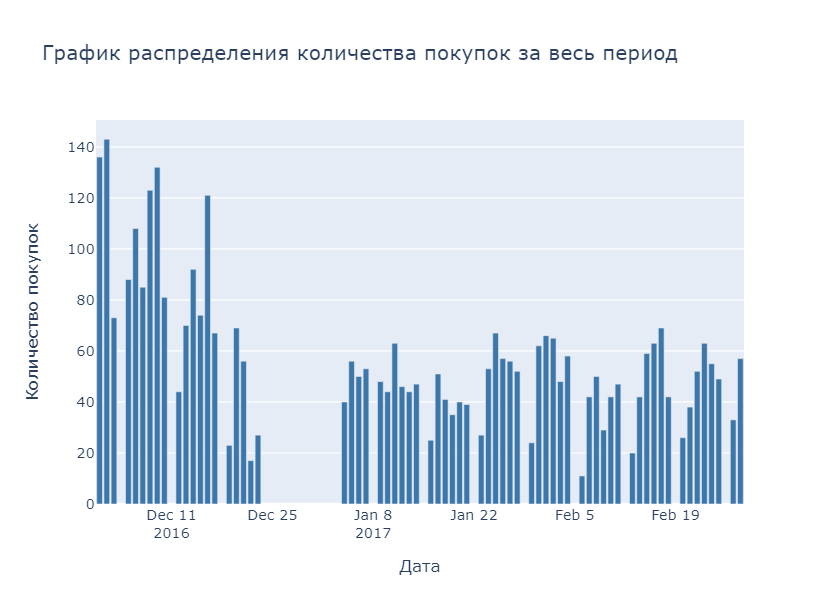

In [28]:
# сгруппируем данные по дате и посчитаем количество покупок
purchase_date = purchase.query('quantity >= 0').groupby('purchase_date').agg({'purchase_id': 'nunique'}).reset_index()

# создадим палитру
palette = ['#1A1941', '#1C1D4B', '#1E2256', '#1F2761', '#212C6D', '#223279', '#233985', '#234191', '#274A95', '#2B5399', 
          '#305B9E', '#3464A2', '#386DA5', '#3D76A9', '#427EAD', '#4687B1','#4B8FB4', '#5098B8', '#55A0BB', '#5AA8BF', 
          '#5FB0C2', '#64B7C5', '#69BFC9', '#6EC6CC', '#73CDCF', '#79D2D0', '#7ED5CF', '#84D7CF', '#89DACE', '#8FDDCE', 
          '#95DFCE', '#9BE2CF', '#A2E4CF', '#A8E7D0', '#AEE9D1', '#B5EBD2', '#BBEDD4', '#C2EFD6']

# выведем столбчатый график
fig = go.Figure(data=[go.Bar(x=purchase_date['purchase_date'], y=purchase_date['purchase_id'])])
fig.update_traces(marker_color=palette[13])
fig.update_layout(title_text='График распределения количества покупок за весь период',
                  xaxis_title='Дата',
                  yaxis_title='Количество покупок')
fig.show()

Мы располагаем данными за 3 месяца - с 2016-12-01 08:26:00 до 2017-02-28 17:04:00.   
По графику видно, что больше всего продаж наблюдалось в декабре 2016 года. За промежуток с 24 декабря по 3 января включительно отсутствуют данные, поэтому скорее всего магазины не работали в эти праздничные дни. Также можно заметить, что магазины работают 6 дней в неделю.

<a id="purchaseshop"></a>
### Распределение покупок по магазинам   

Посмотрим, как покупки распределены по магазинам. Построим для этого график без возвратов товаров.

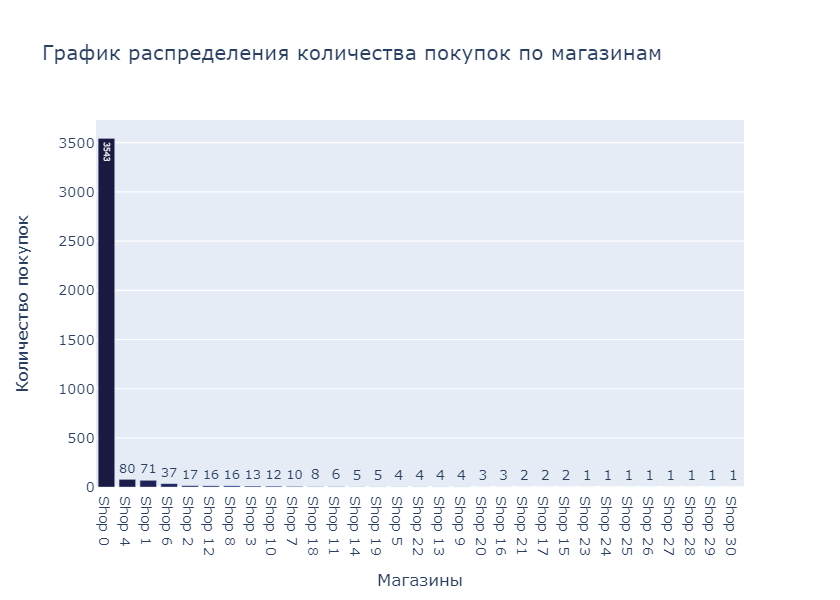

In [29]:
# сгруппируем данные по магазинам и посчитаем количество покупок
purchase_shop = purchase.query('quantity >= 0').groupby('shop_id').agg(
    {'purchase_id': 'nunique'}
).reset_index().sort_values('purchase_id', ascending=False)

# выведем столбчатый график
fig = go.Figure(data=[go.Bar(x=purchase_shop['shop_id'], y=purchase_shop['purchase_id'], text=purchase_shop['purchase_id'])])
fig.update_traces(marker_color=palette)
fig.update_layout(title_text='График распределения количества покупок по магазинам',
                  xaxis_title='Магазины',
                  yaxis_title='Количество покупок')
fig.show()

Наибольшее количество покупок в магазине "Shop 0" - 3543 уникальных чеков то время, как в 8 других магазинах за 3 месяца была совершена всего 1 покупка, что странно. Может быть "Shop 0" расположен очень удачно, а может быть это какой-то склад или оптовик. 

<a id="quantityshop"></a>
### Распределение количества товаров в чеке по магазинам   

Проверим количество товаров в чеке по магазинам. Для лучшей наглядности ограничим количество товаров в чеке до 6000.

,count,mean,std,min,25%,50%,75%,max
shop_id,,,,,,,,
Shop 0,96156.0,7.084613,342.696749,-74216.0,0.0,1.0,6.0,74214.0
Shop 14,154.0,44.759740,121.890986,-41.0,0.0,30.0,59.0,1487.0
Shop 6,1030.0,17.797087,60.817740,-193.0,3.0,7.0,11.0,1439.0
Shop 3,492.0,87.593496,95.263646,-25.0,23.0,71.0,99.0,1439.0
Shop 19,74.0,94.405405,125.339202,-241.0,12.0,41.0,143.0,575.0
Shop 1,1540.0,11.619481,19.984546,-16.0,5.0,9.0,11.0,575.0
Shop 2,252.0,57.519841,82.510386,-19.0,5.0,19.0,95.0,575.0
Shop 16,59.0,20.525424,55.135055,-3.0,1.0,3.0,23.0,406.0
Shop 8,560.0,8.946429,24.598762,-7.0,2.0,5.0,11.0,359.0


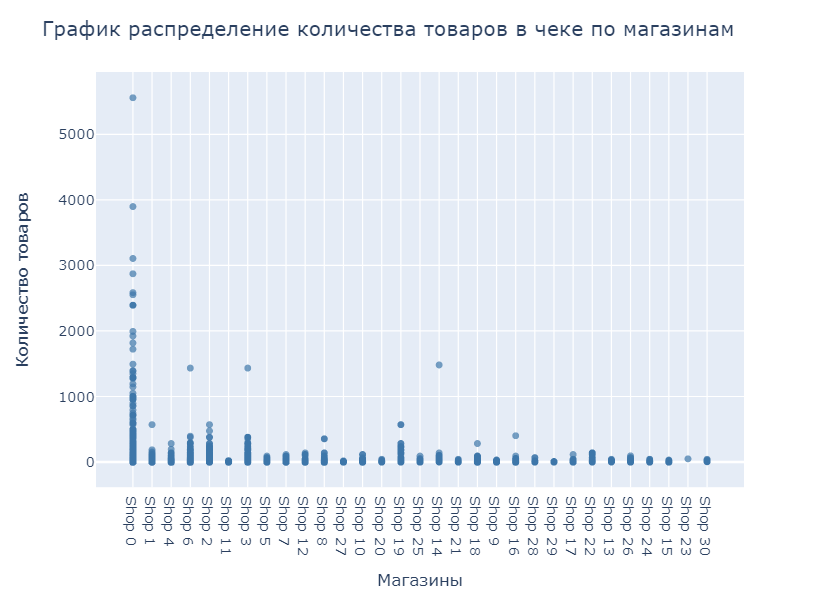

In [30]:
display(purchase.groupby('shop_id')['quantity'].describe().sort_values('max', ascending=False))

# построим график рассеяния
fig = px.scatter(purchase.query('0 < quantity < 6000'), x='shop_id', y='quantity', opacity=0.7)
fig.update_traces(marker_color=palette[13])
fig.update_layout(title="График распределение количества товаров в чеке по магазинам",
                  yaxis_title="Количество товаров",
                  xaxis_title="Магазины")
fig.show()

Видно, что в магазине "Shop 0" присутствуют покупки с количеством товара, превышающем 5000. Также есть покупка на 74214 шт. товара, при этом в остальных магазинах количество товара в чеке не превышает 1500. Возможно "Shop 0" это по совместительству оптовый магазин или интернет-магазин.

<a id="customershop"></a>
### Распределение покупателей и участников программы лояльности по магазинам

Посчитаем среднее количество уникальных покупателей в день, неделю и месяц и регулярность покупок недельной и месячной аудитории клиентов.

In [31]:
# посчитаем количество уникальных покупателей в день, неделю и месяц и регулярность покупок
dau = int(
    purchase.query('quantity >= 0 and customer_id not in @unnamed').groupby('purchase_date')['customer_id'].nunique().mean())
wau = int(
    purchase.query('quantity >= 0 and customer_id not in @unnamed').groupby('purchase_week')['customer_id'].nunique().mean())
mau = int(
    purchase.query('quantity >= 0 and customer_id not in @unnamed').groupby('purchase_month')['customer_id'].nunique().mean())

print('Среднее количество уникальных покупателей в день: {}\n'
      'Среднее количество уникальных покупателей в неделю: {}\n'
      'Среднее количество уникальных покупателей в месяц: {}\n'
      'Регулярность покупок недельной аудитории клиентов: {:.2%}\n'
      'Регулярность покупок месячной аудитории клиентов: {:.2%}'.format(dau, wau, mau, dau/wau, dau/mau)) 

Среднее количество уникальных покупателей в день: 45
Среднее количество уникальных покупателей в неделю: 222
Среднее количество уникальных покупателей в месяц: 794
Регулярность покупок недельной аудитории клиентов: 20.27%
Регулярность покупок месячной аудитории клиентов: 5.67%


Так, в среднем в день совершают покупки 45 клиента, в неделю - 225 клиентов, а в месяц - 794 клиентов. Недельная регулярность покупок составляет 20%, а месячная - 5.7%. Выглядит достаточно не плохо.  
Однако стоит посмотреть, как распределены покупатели по магазинам. Построим для этого график.

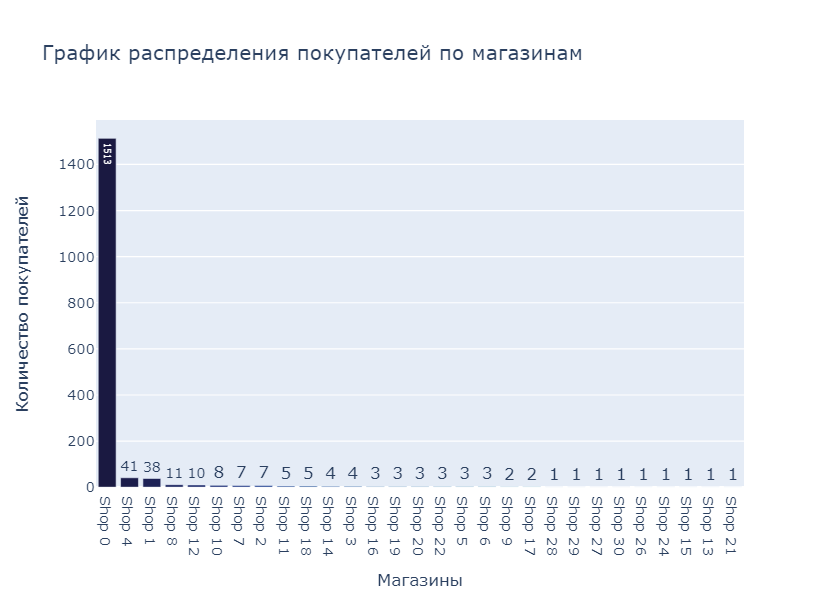

In [32]:
# сгруппируем данные по магазинам и посчитаем количество поукпателей
purchase_customer = purchase.query('quantity >= 0 and customer_id not in @unnamed').groupby('shop_id').agg(
    {'customer_id': 'nunique'}
).reset_index().sort_values('customer_id', ascending=False)


# выведем столбчатый график
fig = go.Figure(data=[go.Bar(
    x=purchase_customer['shop_id'], 
    y=purchase_customer['customer_id'], 
    text=purchase_customer['customer_id'],
    textfont_size = 14)])
fig.update_traces(marker_color=palette)
fig.update_layout(title_text='График распределения покупателей по магазинам',
                  xaxis_title='Магазины',
                  yaxis_title='Количество покупателей')
fig.show()

Заметно, что наибольшее количество покупателей перетягивает на себя `Shop 0`. 
В nоп магазинов по количеству уникальных покупателей попадают `Shop 0` с 1513, `Shop 4` с 41 и `Shop 1` с 38 клиентами. Также есть 9 магазинов, где за все 3 месяца побывал всего 1 покупатель.   
Посмотрим, как распределены участники программы лояльности в магазинам.

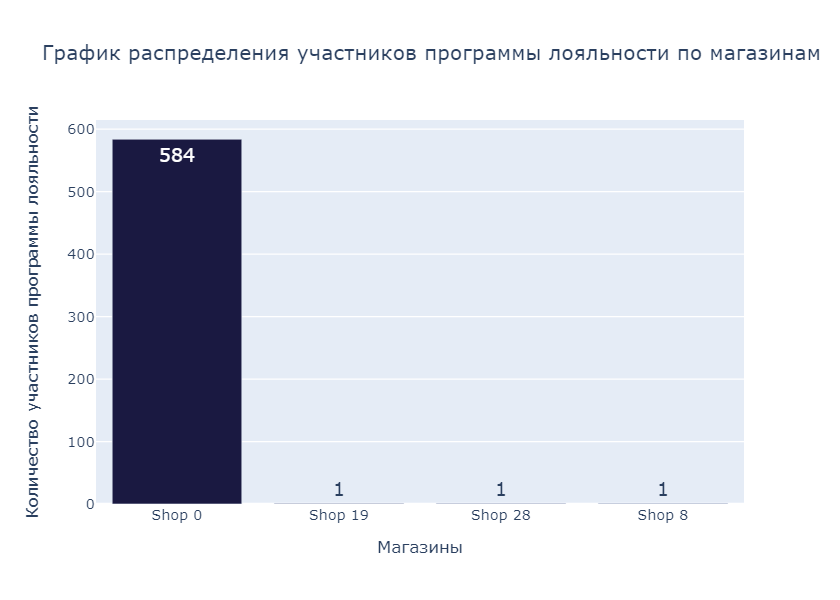

In [33]:
# сгруппируем данные по магазинам и посчитаем количество участников программы
shop_loyalty = purchase.query('loyalty_program == 1').groupby('shop_id').agg(
    {'customer_id': 'nunique'}
).reset_index().sort_values('customer_id', ascending=False)

# выведем столбчатый график
fig = go.Figure(data=[go.Bar(
    x=shop_loyalty['shop_id'], 
    y=shop_loyalty['customer_id'], 
    text=shop_loyalty['customer_id'],
    textfont_size = 16)])
fig.update_traces(marker_color=palette)
fig.update_layout(title_text='График распределения участников программы лояльности по магазинам',
                  xaxis_title='Магазины',
                  yaxis_title='Количество участников программы лояльности')
fig.show()

По графику видно, что 584 участника программы лояльности совершили покупки в магазине `Shop 0` и по 1 участнику программы - в магазинах `Shop 8`, `Shop 19` и `Shop 28`. В остальных магазинах отсутствуют участники программы лояльности. Поскольку у нас только тестовый период, т.е. программу лояльности только ввели, возможно в некоторых магазинах данная программа еще не была введена или не набирает такую популярность, судя по количеству покупателей в магазинах. Это стоит уточнить у заказчика. 

**Вывод по разделу**

* Приняли, что чеки с отрицательными значениями, cодержащие в названии букву "C" означают Cancel - отмена, т.е. возврат товара. Остальные чеки без содержания буквы "С" удалили, приняв, что это ошибка или сбой.

* Предположили, что нулевое количество товара в чеке это различные акции и оставили их не тронутыми.

* Мы располагаем данными за 3 месяца - с 2016-12-01 08:26:00 до 2017-02-28 17:04:00. Больше всего продаж наблюдалось в декабре 2016 года. В праздничные дни с 24 декабря по 3 января включительно скорее всего магазины не работали. Также выяснили, что магазины работают 6 дней в неделю.

* В данных 31 магазинов сети. Самый крупный `Shop 0` - с 3543 уникальными чеками, с покупками с количеством товара, превышающем 74к, с 2094 уникальными покупателями и с 584 участниками программы. Возможно `Shop 0` это по совместительству оптовый магазин или интернет-магазин.

* Также присутствуют 8 магазинов, где за 3 месяца была совершена всего 1 покупка, и 9 магазинов, где за все 3 месяца побывал всего 1 покупатель. Во всех магазинах, кроме `Shop 0`, количество товара в чеке не превышает 1500. 

* Всего имееются 4 магазина, где были совершены покупки по программе лояльности, а именно `Shop 0` (584 участников) и по 1 участникув каждом из `Shop 8`, `Shop 19` и `Shop 28`.

<a id="loyalty"></a>

## Анализ программы лояльности

Перед анализом программы лояльности посчитаем сумму каждого чека.

In [34]:
# в отдельном столбце посчитаем цену за n количество товаров,
# затем сгруппируем данные по чеку и посчитаем сумму стоимости товаров в этом чеке
# и соедениим две таблицы по чеку
purchase['price'] = purchase['quantity'] * purchase['price_per_one']
revenue = purchase.groupby('purchase_id').agg({'price': 'sum'}).rename(columns={'price': 'revenue'}).reset_index()
purchase = purchase.merge(revenue, on='purchase_id')

<a id="loyaltycustomer"></a>

### Анализ покупателей

Посчитаем соотношение участников программы лояльности и обычных покупателей.

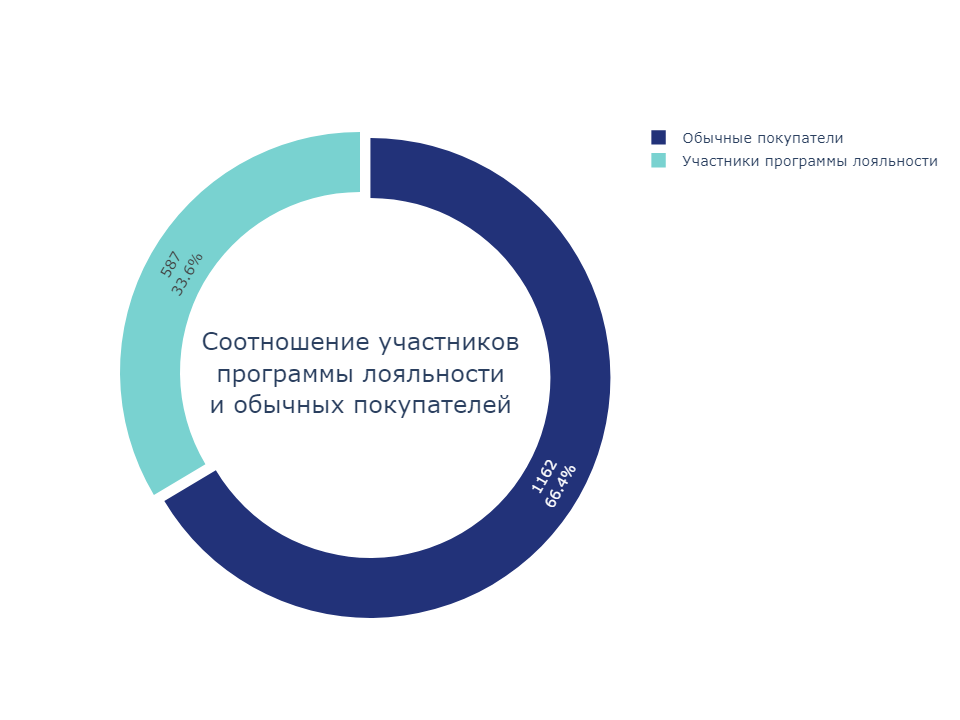

In [35]:
# сгруппируем данные по столбцу loyalty_program и посчитаем количество уникальных покупателей по каждой группе
loyalty = purchase.query('customer_id not in @unnamed').groupby('loyalty_program').agg({'customer_id': 'nunique'})

# выведем круговую диаграмму
fig = go.Figure(data=[go.Pie(labels=['Обычные покупатели', 'Участники программы лояльности'], 
                             values=loyalty['customer_id'],
                             pull=[0.05, 0],
                             hole=0.75)])
fig.update_layout(width=800,
                  height=600,
                  annotations=[dict(text='Соотношение участников<br> программы лояльности <br>и обычных покупателей', 
                                   x=0.5, 
                                   y=0.5, 
                                   font_size=20, 
                                   showarrow=False)])
fig.update_traces(textinfo='percent + value', marker=dict(colors=[palette[5], palette[25]]))
fig.show()

Судя по диаграмме, 33,6% покупателей являются участниками программы лояльности и 66,4% являются покупателями, не участвовавшие в программе.  
Определим количество уникальных покупателей по дням, неделям и месяцам с и без программы лояльности. Для этого напишем функцию, позволяющую строить графики, меняя ось дат, название графика и название оси x.

In [36]:
def bar_date(column, title):    

    """ Функция на вход принимает название столбца, 
    название оси х и часть названия графика. 
    Группирует данные по дате и программе лояльности и считает уникальных покупателей.
    Строит график распределения уникальных покупателей по дате"""   
    
#   построим столбчатый график
    for d, x, t  in [
    ['purchase_date', 'Дата', 'дням'],
    ['purchase_week', 'Недели', 'неделям'],
    ['purchase_month', 'Месяцы', 'месяцам']]:
        
#       создадим таблицу сгруппированную по столбцу column и по 'loyalty_program', 
#       посчитаем количество уникальных пользователей  
        data = purchase.query('quantity > 0 and customer_id not in @unnamed').groupby([d, 'loyalty_program']).agg(
            {column: 'nunique'}
        ).reset_index()

        data['loyalty_program'] = data['loyalty_program'].replace({0:'Обычный покупатель', 1:'Участник программы лояльности'})
    
        fig = px.bar(data, x=d, y=column, color='loyalty_program', 
                 color_discrete_map={'Обычный покупатель': palette[5], 'Участник программы лояльности': palette[23]}, 
                 barmode='group')
        fig.update_layout(title_text='График распределения уникальных {} по {}'.format(title, t),
                          xaxis_title=x,
                          yaxis_title='Количество покупателей',
                          legend=dict(x=.6,  y=.98), 
                          legend_title=dict(text = 'Покупатели'))
        fig.show()

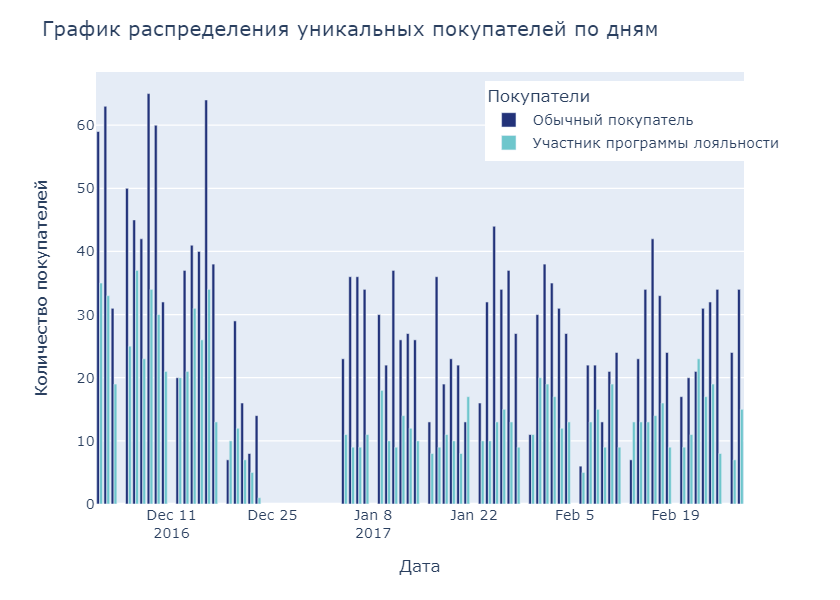

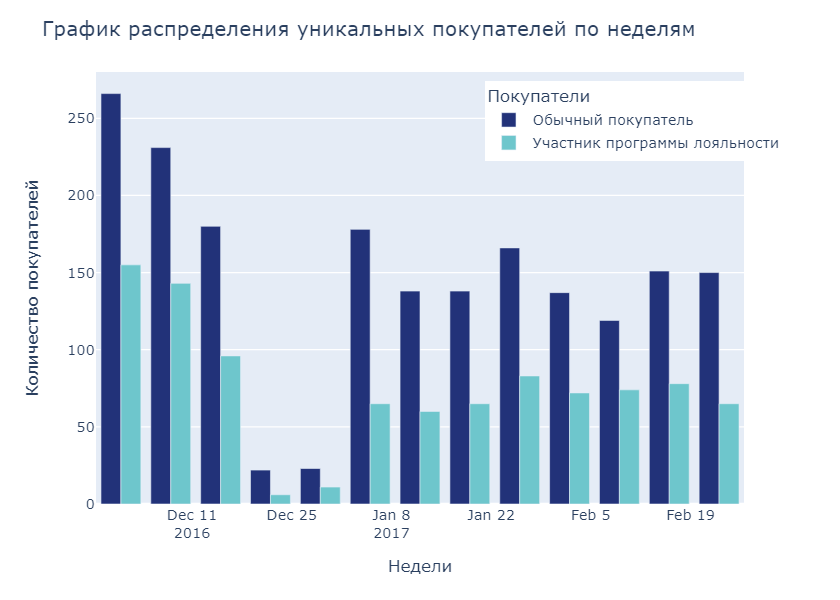

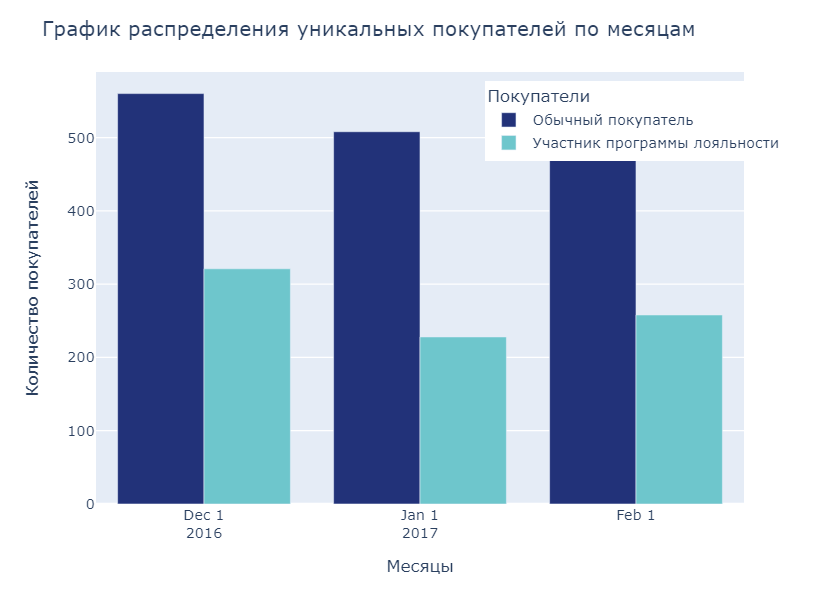

In [37]:
# выведем 3 графика с помощью функции
bar_date('customer_id', 'покупателей')

В разбивке по дням заметно, что регулярно количество покупателей без подписки превосходит количество покупателей с подпиской на программу лояльности, кроме 19 декабря и 13 февраля, там обратная ситуация - участников программы лояльности больше. Возможно это связано с акциями или подарками для участников программы перед праздником дня влюбленных 14 февраля. Также 30 января и 22 февраля (как перед 23.02) равное количество покупателей в двух группах.
На 51 неделю 2016 года видно, что количество покупателей резко снизилось, это связано с тем, что в конце декабря и в начале января магазины не работали. Но уже в первой половине января количесвто клиентов снова возрастает.  
Итого по графикам видно, что больше всего покупателей было в декабре, как раз перед новогодними празниками, причем как обычных покупателей, так и участников программы лояльности.  

<a id="loyaltypurchase"></a>

### Анализ покупок

Посмотрим на распрделение покупок по дням, неделям и месяцам обычных покупателей и участников программы лояльности.

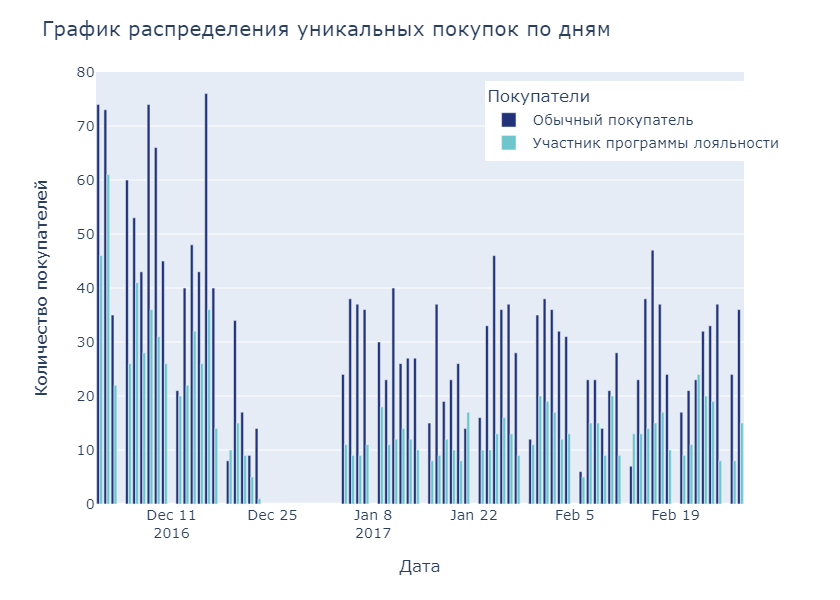

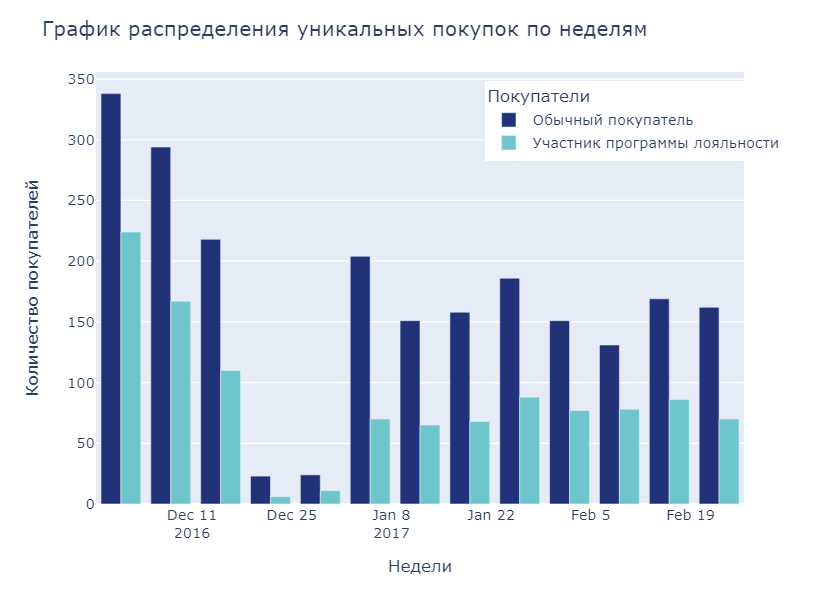

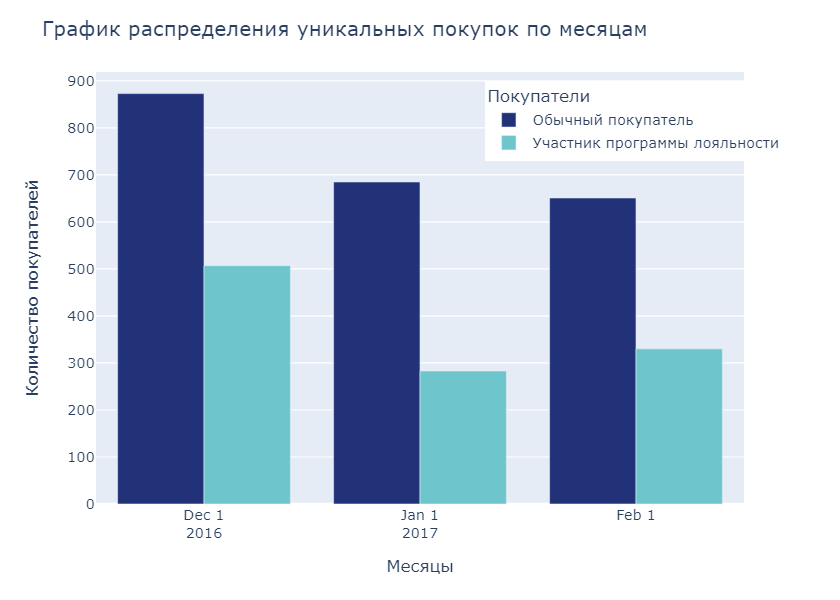

In [38]:
bar_date('purchase_id', 'покупок')

Количество покупок без программы лояльности регулярно больше, что логично, ведь количество таких покупателей тоже превышает участников программы. Лишь 19 декабря, 21 января, 13 и 22 февраля количество покупок больше у платящих за подписку клиентов, что также мы наблюдали в распределении уникальных покупателей по датам.   

<a id="LTV"></a>

### Анализ среднего чека и LTV 

Посмотрим, как отличается средний чек у участников программы и обычных покупателей. Для этого сначала посмотрим на распределение выручки чеков.

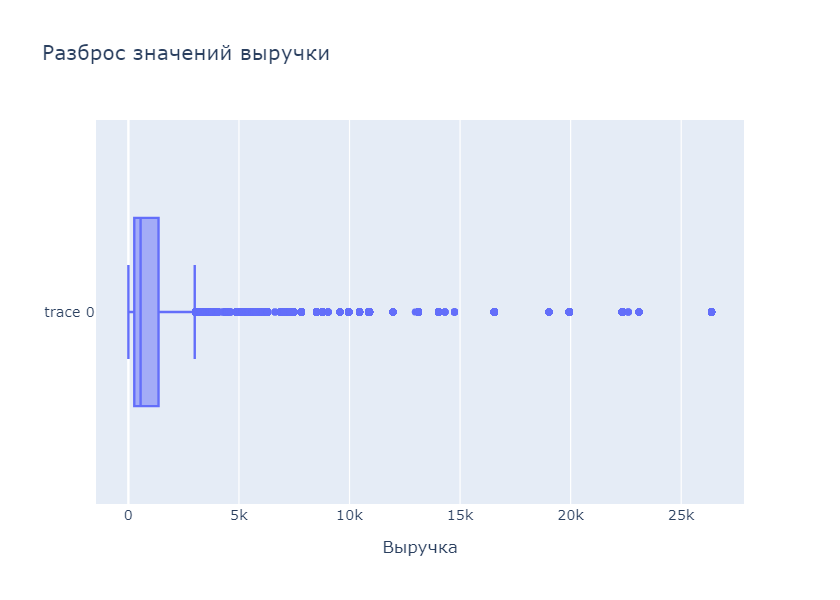

In [39]:
# построим диаграмму размаха
fig = go.Figure(go.Box(x=purchase.query('0 < revenue < 30000')['revenue']))
fig.update_layout(title="Разброс значений выручки", xaxis_title="Выручка")
fig.show()

Видно, что разброс значений достаточно огромный, поэтому мы ограничили на графике выручку до 30000, чтобы график был более наглядный. В таком случае, лучше считать средний чек по медиане.  
Сравним средний чек с и без программы лояльности. Для этого напишем функию расчета среднего чека и вывода графиков по дням, неделям и месяцам.

In [40]:
def median_check(date, x, text):
    
    """ Функция на вход принимает название столбца, 
    название оси х и часть названия графика. 
    Создает сводную таблицу по дате и программе лояльности и считает медиану суммы чека.
    Строит график распределения медианной суммы чека по дате"""   
    
#   создаем сводную таблицу по дате и программе лояльности, считаем медиану чека
    check_median = purchase.query('quantity > 0').drop_duplicates(subset='purchase_id').pivot_table(
        index=date, columns='loyalty_program', values='revenue', aggfunc='median'
    ).reset_index().rename(columns={0: 'Обычные покупатели', 1: 'Участники программы лояльности'})

#   строим график медианной суммы чека по датам
    fig = px.line(check_median, x=date, y=['Обычные покупатели', 'Участники программы лояльности'])
    fig.update_layout(title_text='График среднего чека по {}'.format(text),
                      xaxis_title=x,
                      yaxis_title='Выручка',
                      legend=dict(x=.5,  y=-.5, xanchor='center', orientation='h'), 
                      legend_title=dict(text = 'Покупатели'),
                      width=1000, 
                      height=600,)
    fig.update_xaxes(tickformat="%B %d, %Y",
                     ticks= "outside",
                     ticklabelmode= "period", 
                     tickcolor= "black", 
                     ticklen=10,
                     rangeslider_visible=True)
    fig.show()

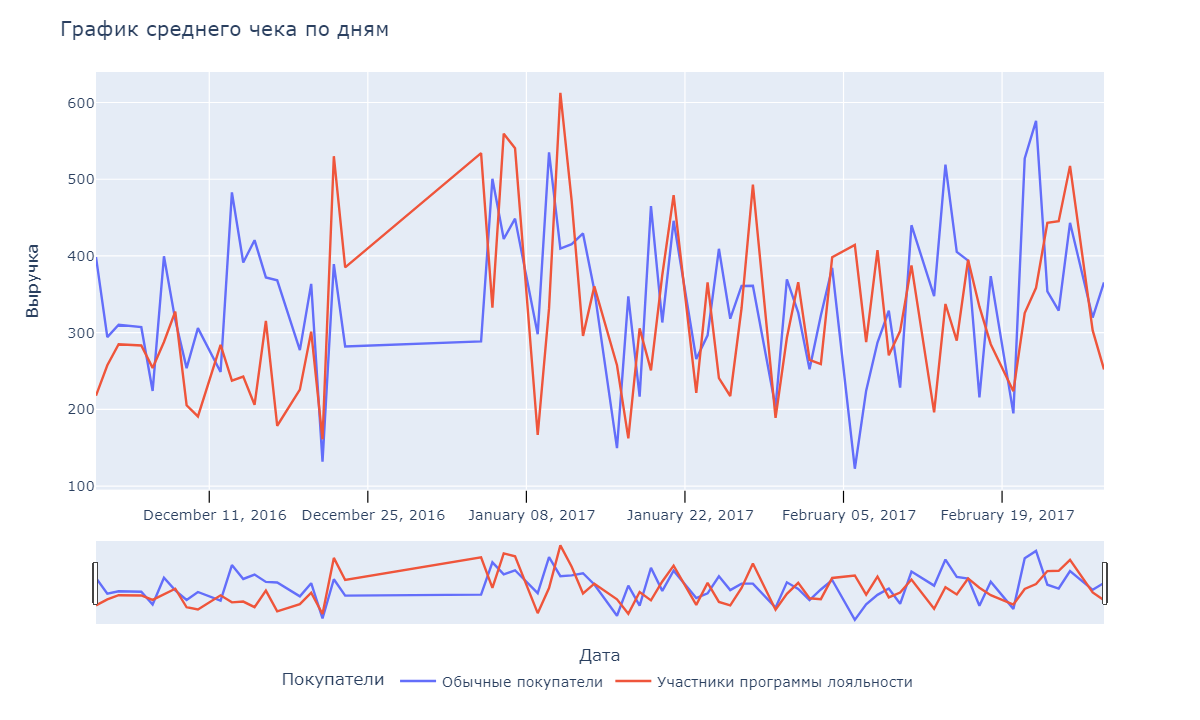

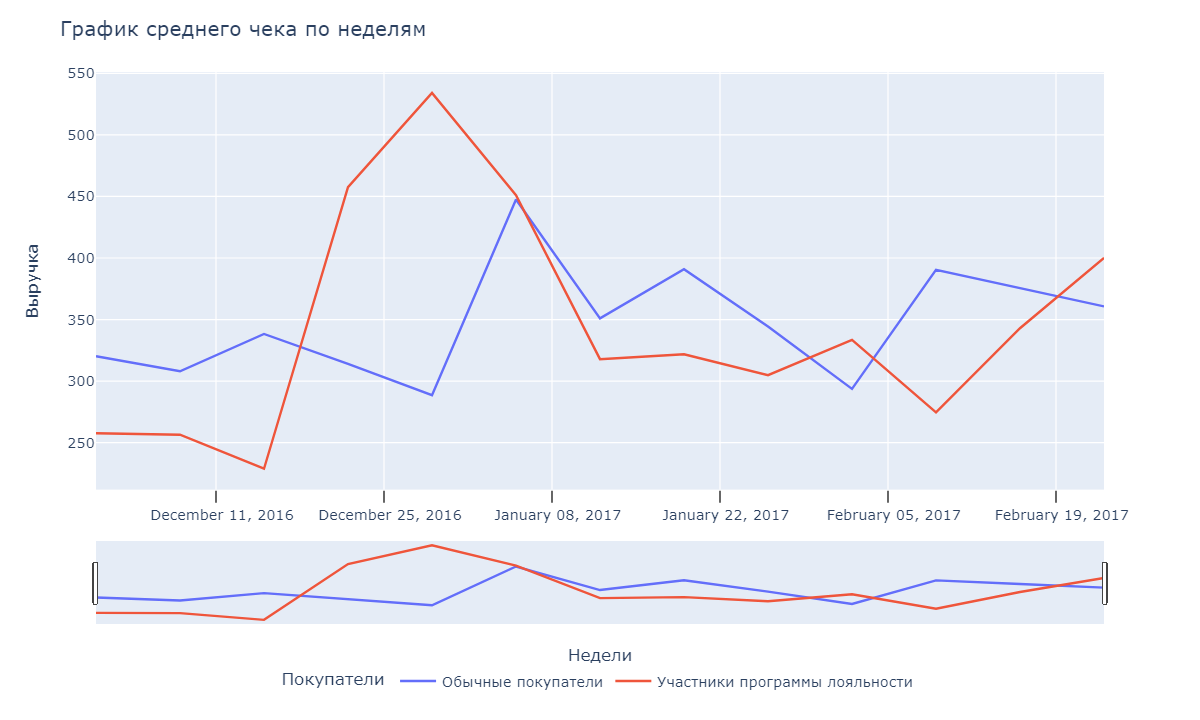

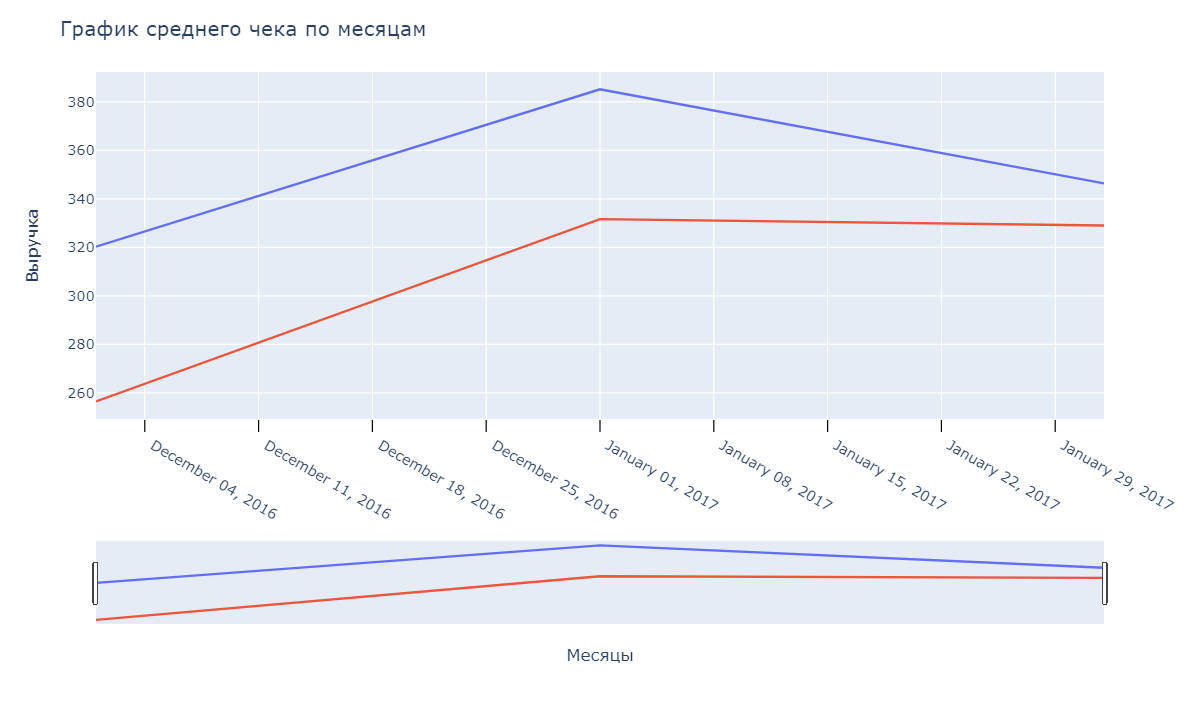

In [41]:
# выведем 3 графика с помощью функции
for c, t, x in [
    ['purchase_date', 'Дата', 'дням'],
    ['purchase_week', 'Недели', 'неделям'],
    ['purchase_month', 'Месяцы', 'месяцам']
]:
    median_check(c, t, x)

Стоит отметить, что в 1 неделю 2017 входят всего 4 дня - 4, 5, 6 и 7 января, поскольку с 24 декабря по 4 января магазины не работали. Поэтому данных в эту неделю будет меньше и возможно из-за этого средний чек на графике за эту неделю показывает пик или наоборот спад.

График чека по дням показывает, что средний чек у обычных покупателей зачастую выше, чем у участников программы лояльности. Самые пики у участников программы приходятся на конец декабря и начало января, т.е. в новогодние праздники. Также начиная с января у покупателей с картой средний чек все чаще становится выше.  
На графике среднего чека по неделям и месяцам также видно, что чаще чек участников программы ниже, чем чек обычных покупателей. Только в феврале разница между чеками становится меньше.    
Стоит отметить, что поскольку мы не занем точные цены за товары и скидки на них, то средний чек стоит ставить под сомнение.

Посчитаем сумму денег, которую в среднем приносит один клиент со всех покупок, т.е. LTV. Для этого сначала напишем функцию для создания профилей клиентов, для расчета LTV, для группировки по желаемым признакаам (по программе лояльности и без нее) и для визуализации LTV.

In [42]:
# функция для создания пользовательских профилей

def get_profiles(purchase):

    # находим параметры первых покупок
    profiles = (
        purchase.query('quantity > 0').sort_values(by=['customer_id', 'purchase_time'])
        .groupby('customer_id')
        .agg(
            {
                'purchase_time': 'first',
                'loyalty_program': 'first',
            }
        )
        .rename(columns={'purchase_time': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    return profiles

In [43]:
# функция для расчёта LTV

def get_ltv(
    profiles,
    purchase,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchase.query('quantity > 0')[['customer_id', 'purchase_date', 'price']], on='customer_id', how='left'
    ) 
    
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['purchase_date'] - result_raw['dt']
    ).dt.days
    
    # рассчитываем количество клиентов, совершившие покупки по программе лояльности на 32 день
    loyalty_32lt = result_raw.query('lifetime == 32 and loyalty_program == 1')['customer_id'].nunique()
    
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'customer_id': 'nunique'})
            .rename(columns={'customer_id': 'cohort_size'})
        )
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='price', aggfunc='sum'
        )
        # добавляем 200 р за программу лояльности на 0 день лайфтайма        
        result.loc[1,0] = result.loc[1,0] + 200 * cohort_sizes.loc[1, 'cohort_size']
        # добавляем 200 р за продление программы лояльности на 32 день лайфтайма        
        result.loc[1,31] = result.loc[1,31] + 200 * loyalty_32lt
        
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
       
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # возвращаем таблицы LTV и ROI
        return result

    # получаем таблицы LTV и ROI
    result_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    ) 


    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
    )

In [44]:
# функция для визуализации LTV

def plot_ltv(ltv):

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size']).T

    # график — кривые ltv
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=ltv.index, y=ltv[0], name='Обычные покупатели'))
    fig.add_trace(go.Scatter(x=ltv.index, y=ltv[1], name='Участники программы лояльности'))
    fig.update_layout(title_text='<b>LTV<b>',
                      xaxis_title='Лайфтайм',
                      legend_title=dict(text = 'Покупатели'),
                      legend=dict(x=.5,  y=-.15, xanchor='center', orientation='h'),)
    fig.show()

Создадим профили клиентов с помощью написанной функции `get_profiles()`, передав ей данные о покупках. 

In [45]:
# профили клиентов
profiles = get_profiles(purchase.query('customer_id not in @unnamed'))
profiles.head()

,customer_id,first_ts,loyalty_program,dt,month
0,18025.0,2017-01-18 10:01:00,0,2017-01-18,2017-01-01
1,18026.0,2016-12-07 14:57:00,0,2016-12-07,2016-12-01
2,18027.0,2016-12-16 19:09:00,0,2016-12-16,2016-12-01
3,18029.0,2017-02-02 16:01:00,0,2017-02-02,2017-02-01
4,18031.0,2017-02-16 12:33:00,0,2017-02-16,2017-02-01


Зададим момент и горизонт анализа данных так, чтобы не захватить праздничные выходные.

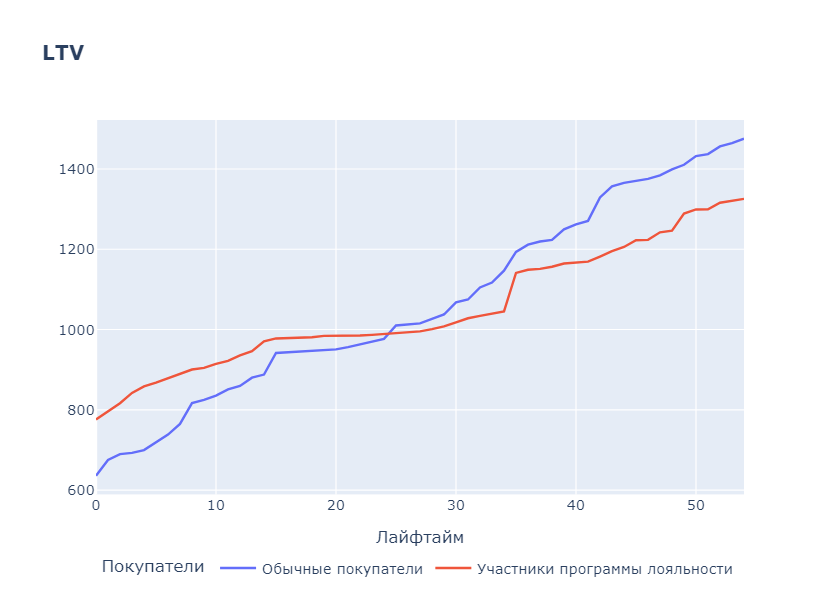

In [46]:
# момент анализа
observation_date = profiles['dt'].max()

# горизонт анализа
horizon_days = 55

# считаем LTV
ltv_raw, ltv_grouped = get_ltv(
    profiles,
    purchase,
    observation_date,
    horizon_days,
    dimensions=['loyalty_program'],
)

# строим график
plot_ltv(ltv_grouped)

По графику можно сделать вывод, что LTV участников программы лояльности выше, чем у обычных покупателей до 24 дня жизни покупателя. Дальше LTV покупателей, не участвовавших в программе, опережает показатель клиентов, платящих за подписку.   
Судя по всему, с учетом оплаты карты (подписки на программу) можно предположить по LTV, что программа лояльности вероятнее всего не работает.

**Вывод по разделу:**

* В имеющихся данных 25,7% покупателей являются участниками программы лояльности и 74,3% являются покупателями, не участвовавшие в программе.

* Наибольшее количество покупателей наблюдается в декабре перед новогодними праздниками. В разбивке по датам стабильно количество покупателей без подписки превосходит количество покупателей с подпиской на программу лояльности. Только перед праздниками количество участников программы лояльности больше обычных покупателей, что скорее связано с выгодными акциями и подарками для держателей карт программы.

* По количеству покупок ситуация схожая с количеством самих покупателей. Можно предположить, что на одного покупателя приходится примерно одна покупка.

* Из-за больших выбросов в сумме чека средний чек считали по медиане. Однако средний чек у обычных покупателей чаще выше, чем у участников программы лояльности. Самые пики у участников программы приходятся на конец декабря и начало января, т.е. в новогодние праздники.

* Также посчитали метрику LTV. Учли стоимость подписки в 200р в месяц на программу лояльности. В среднем участник программы лояльности приносил бизнесу больше выручки, чем обычный покупатель до 24 дня жизни, но далее LTV покупателей, не участвовавших в программе, опережает показатель клиентов, платящих за подписку. 
    На основе всего этого можно предположить, что программа лояльности не работает, хоть и изначально показывала неплохие результаты.

<a id="stats"></a>

## Статистический анализ данных

<a id="check"></a>

### Гипотеза о средних чеках

Сформулируем гипотезы:  

* Нулевая гипотеза H0: различий в среднем чеке участников программы лояльности и остальных покупателей нет.
* Альтернативная гипотеза H1: различия в среднем чеке участников программы лояльности и остальных покупателей есть.
 
Создадим функцию, которая будет создавать две таблицы, по которым будем проверять гипотезы, и два графика распределения данных. 

In [47]:
def sampling_loyalty_program(column, xlabel):
    
    """Функция прринимает столбец, по которому мы будем проверять гипотезы, 
    и строку подписи оси на графиках.
    На выход выдает две таблицы, отфильтрованные по программе лояльности, 
    сгруппированные по чеку и агрегированные по входящему столбцу, 
    также два графика распределения данных в разбивке по покупателям."""
    
#   таблицы лояльных и не лояльных покупателей
    loyalty = purchase.query('loyalty_program == 1 and 0 < quantity').pivot_table(
    index = 'purchase_id', values = column, aggfunc = 'sum')
    not_loyalty = purchase.query('loyalty_program == 0 and 0 < quantity').pivot_table(
    index = 'purchase_id', values = column, aggfunc = 'sum')
    
#   вывод графиков
    sns.set_style('darkgrid')

    plt.figure(figsize=(15, 7))
    plt.suptitle('Распределение данных', fontsize=18)

    ax1 = plt.subplot(1, 2, 1)
    sns.distplot(loyalty[column], bins=100, color = palette[5], kde_kws={'linewidth': 2}, ax=ax1)
    plt.xlabel(xlabel, fontsize=14)
    plt.title('Участники программы лояльности', fontsize=16)

    ax2 = plt.subplot(1, 2, 2)
    sns.distplot(not_loyalty[column], bins=100, color = palette[5], kde_kws={'linewidth': 2}, ax=ax2)
    plt.xlabel(xlabel, fontsize=14)
    plt.title('Обычные покупатели', fontsize=16)
    plt.show()
    
    return loyalty, not_loyalty

Применим функцию для проверки гипотезы о среднем чеке. Посмотрим на распределение суммы чеков по покупателям.

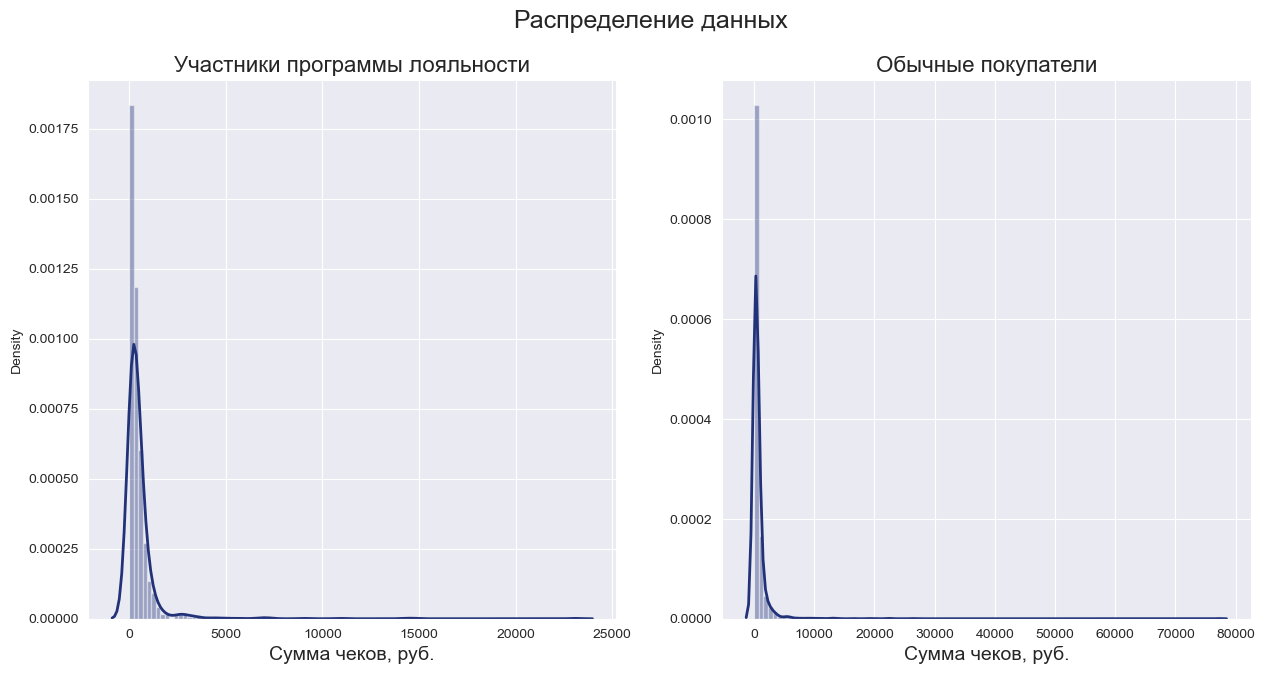

In [48]:
loyalty_program, not_loyalty_program = sampling_loyalty_program('price', 'Сумма чеков, руб.')

Поскольку данные не подчиняются закону нормального распределения и в них присутствуют выбросы, то для проверки гипотез будем использовать критерий Манна-Уитни.   
Проверим двухстороннюю гипотезу и выведем относительное различие в реднем чеке между двумя группами покупателей, чтобы точнее сделать вывод о различии или о его отсутствии.

In [49]:
# сохраняем в переменные чеки 
sampleA = loyalty_program['price']
sampleB = not_loyalty_program['price']

# критический уровень статистической значимости
alpha = 0.05

# находим p-value с помощью теста Манна-Уитни
results = stats.mannwhitneyu(sampleA, sampleB)

print("p-value: {0:.5f}".format(results[1]))

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу: разница статистически значима")
else:
    print("Не получилось отвергнуть нулевую гипотезу: вывод о различии сделать нельзя")

print("Относительное различие в среднем чеке между группами {0:.3f}"
      .format(sampleB.mean() / sampleA.mean() - 1))

p-value: 0.00056
Отвергаем нулевую гипотезу: разница статистически значима
Относительное различие в среднем чеке между группами 0.322


По данным имеются статистически значимые различия в среднем чеке между группами участников программы лояльности и остальными покупателями. Относительный прирост среднего чека группы обычных покупателей к группе участников программы лояльности составляет 32%.   
ПРоверим вторую гипотезу.

<a id="statsquantity"></a>

### Гипотеза о количестве товара в чеке

Сформулируем гипотезы:  

* Нулевая гипотеза H0: различий между средними количествами покупок участников программы лояльности и остальных покупателей нет.
* Альтернативная гипотеза H1: средние количества покупок участников программы лояльности и остальных покупателей различны.

Теперь еще раз посмотрим на распределение данных по количеству товаров в чеке.

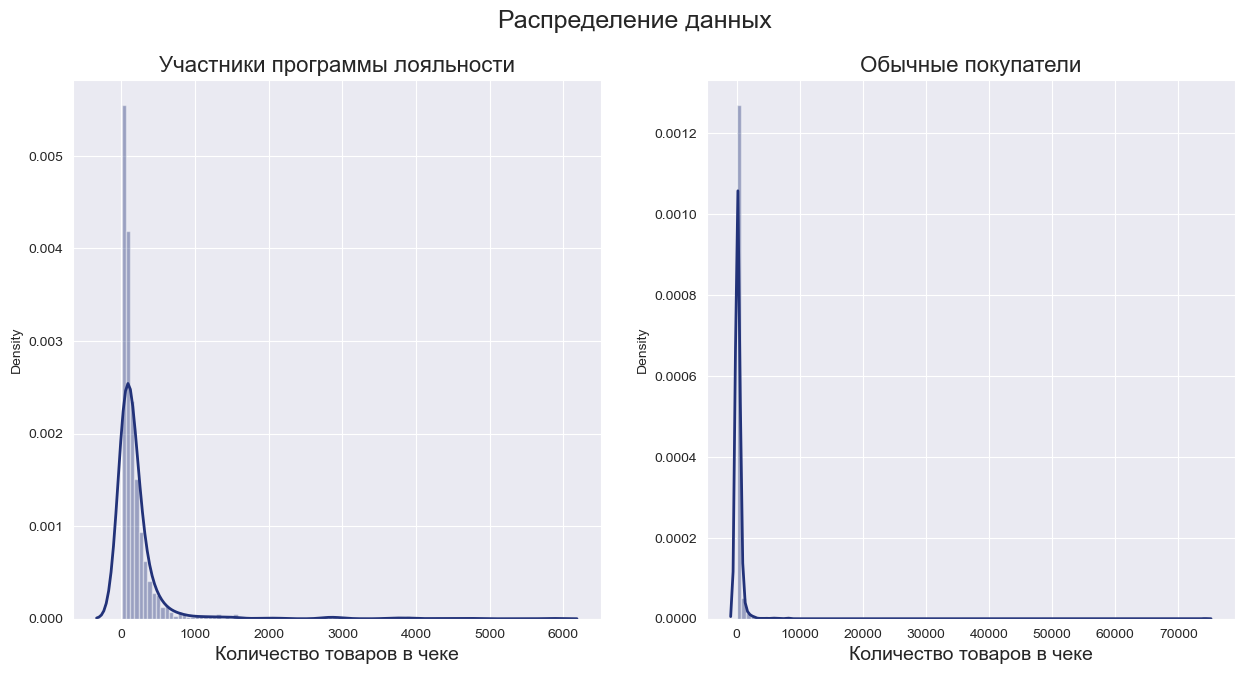

In [50]:
loyalty_program, not_loyalty_program = sampling_loyalty_program('quantity', 'Количество товаров в чеке')

Также как и в прошлый раз данные не подчиняются закону нормального распределения и в них присутствуют выбросы, поэтому для проверки гипотез будем тоже использовать критерий Манна-Уитни.

In [51]:
# сохраняем в переменные чеки заказов в группах А и В
sampleA = loyalty_program['quantity']
sampleB = not_loyalty_program['quantity']

# критический уровень статистической значимости
alpha = 0.05

# находим p-value с помощью теста Манна-Уитни
results = stats.mannwhitneyu(sampleA, sampleB)

print("p-value: {0:.5f}".format(results[1]))

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу: разница статистически значима")
else:
    print("Не получилось отвергнуть нулевую гипотезу: вывод о различии сделать нельзя")

print("Относительное различие в среднем количестве товара в чеке между группами {0:.3f}"
      .format(sampleB.mean() / sampleA.mean() - 1))

p-value: 0.00449
Отвергаем нулевую гипотезу: разница статистически значима
Относительное различие в среднем количестве товара в чеке между группами 0.313


p-value значительно меньше 0,05, что говорит о статистическом значимом различии между группами. Но судя по относительному различию среднее количество товара в чеке у участников программы лояльности на 31,3% меньше, чем у остальных покупателей.

**Вывод по разделу**

По результатам проверки гипотез можно сделать выводы:

* Различия по среднему чеку между группами покупателей статистически значимы;
* Относительное различие между группами говорит о том, что средний чек группы участников программы лояльности ниже среднего чека остальных покупателей на 32%.


* Различия по среднему количеству товаров в чеке между группами покупателей статистически значимы;
* Относительное различие по среднему количеству товаров в чеке между группами говорит о том, что результаты участников программы лояльности хуже, чем у остальных покупателей на 31%.

<a id="rec"></a>

## Общий вывод

<div class="alert alert-info">   

------------------------------------------------------------------------------------------------------------------------------
    
**1. Была изучена общая информация о датафреймах.**
    
Файл, содержащий информацию о покупках в магазине строительных материалов, имеет всего 105335 записей и 7 столбцов.
Файл, содержащий информацию о стоимости за единицу товара в магазине строительных материалов, имеет всего 9969 записей и 2 столбца. 
   
    
Итог:

* Столбцы `purchasedate`, `CustomerID` и `loyalty_program` имеют некорректный тип данных
* Пропуски присутствуют в столбце `CustomerID` 
* Наименования столбцов записаны некорректно
* По гистограмме и краткому описанию количества товаров в чеке можно заметить большой разброс от -74216 до 74214.
* По гистограмме и краткому описанию стоимости товара можно заметить большой разброс от 0 до 16888.

-----------------------------------------------------------------------------------------------------------------------------  
    
**2. В разделе предобратоки данных:**
  
    
* переименовали столбцы
* изменили типы данных в `purchase_date`, `customer_id` и `loyalty_program`
* заменили пропущенные значения в `customer_id`
* удалили строки-дубликаты и заменили стоимость за единицу товара медианным значением
* добавили 3 столбца с датой, неделей и месяцем
* объединили два датафрейма

Процент потери данных составил 0.98%
    
-------------------------------------------------------------------------------------------------------------------------------
    
**3. Исследовательский анализа данных:**

* **Анализ количества товаров в чеке**

    - Приняли, что чеки с отрицательными значениями, cодержащие в названии букву "C" означают Cancel - отмена, т.е. возврат товара. Остальные чеки без содержания буквы "С" удалили, приняв, что это ошибка или сбой.

    - Предположили, что нулевое количество товара в чеке это различные акции и оставили их не тронутыми.

    Процент потери данных: 1.18%
    
    
* **Распределение покупок за весь период** 
    
    - Мы располагаем данными за 3 месяца - с 2016-12-01 08:26:00 до 2017-02-28 17:04:00.   
    Больше всего продаж наблюдалось в декабре 2016 года. В праздничные дни с 24 декабря по 3 января включительно скорее всего магазины не работали. Также выяснили, что магазины работают 6 дней в неделю.
    
    
* **Распределение покупок по магазинам**
    
    - В данных 31 магазинов сети. Самый крупный `Shop 0` - с 3543 уникальными чеками. В 8 других магазинах за 3 месяца была совершена всего 1 покупка.

    
* **Распределение количества товаров в чеке по магазинам**    
    
    - В магазине "Shop 0" присутствуют покупки с количеством товара, превышающем 5000. Также есть покупка на 74214 шт. товара, при этом в остальных магазинах количество товара в чеке не превышает 1500.  
    Возможно "Shop 0" это по совместительству оптовый магазин или интернет-магазин.    
        
    
* **Распределение покупателей и участников программы лояльности по магазинам**    
    Среднее количество уникальных покупателей в день: 45   
    Среднее количество уникальных покупателей в неделю: 225  
    Среднее количество уникальных покупателей в месяц: 794  
    Регулярность покупок недельной аудитории клиентов: 20%  
    Регулярность покупок месячной аудитории клиентов: 5.67%  
    
    - Присутствуют 10 магазинов, где за все 3 месяца побывал всего 1 покупатель. 
    - Всего имееются 4 магазина, где были совершены покупки по программе лояльности, а именно `Shop 0` (584 участников) и по 1 участнику в каждом из `Shop 8`, `Shop 19` и `Shop 28`. В остальных магазинах отсутствуют участники программы лояльности.
    Поскольку у нас только тестовый период, т.е. программу лояльности только ввели, возможно в некоторых магазинах данная программа еще не была введена или не набирает такую популярность, судя по количеству покупателей в магазинах.
    
-------------------------------------------------------------------------------------------------------------------------------
    
**4. Анализ программы лояльности**  
    
* **Анализ покупателей**
    
    - В имеющихся данных 25,7% покупателей являются участниками программы лояльности и 74,3% являются обычными покупателями.
    
    - Наибольшее количество покупателей наблюдается в декабре перед новогодними праздниками. Кколичество покупателей без подписки стабильно превосходит количество покупателей, участвовавших в программе лояльности. Только перед праздниками количество участников программы лояльности больше обычных покупателей, что скорее связано с выгодными акциями и подарками для держателей карт программы.

* **Анализ покупок**
    
    - Количество покупок без программы лояльности регулярно больше, что логично, ведь количество таких покупателей тоже превышает участников программы. Лишь по празднам появлятся ажиотаж и количество покупок у лояльных клиентов немного превышает еоличество покупок нелояльных, как например, 13 февраля перед праздником Дня святого Валентина.

* **Анализ среднего чека и LTV**
    
    - Из-за больших выбросов в сумме чека средний чек считали по медиане.   
    Средний чек у обычных покупателей зачастую выше, чем у участников программы лояльности. Самые пики у участников программы приходятся на конец декабря и начало января, т.е. в новогодние праздники.

    - Также посчитали метрику LTV. Учли стоимость подписки в 200р в месяц на программу лояльности. В среднем участник программы лояльности приносил бизнесу больше выручки, чем обычный покупатель до 24 дня жизни, но далее LTV покупателей, не участвовавших в программе, опережает показатель клиентов, платящих за подписку. На основе всего этого можно предположить, что программа лояльности не работает, хоть и изначально показывала неплохие результаты.
 
---------------------------------------------------------------------------------------------------------------------------    

**5. Статистический аналих данных**
    
* **Гипотеза о средних чеках**

    Гипотезы:  

    - Нулевая гипотеза H0: различий в среднем чеке участников программы лояльности и остальных покупателей нет.  
    - Альтернативная гипотеза H1: различия в среднем чеке участников программы лояльности и остальных покупателей есть.    
    
    Вывод: 
    - Различия по среднему чеку между группами покупателей статистически значимы;
    - Относительное различие между группами говорит о том, что средний чек группы участников программы лояльности ниже среднего чека остальных покупателей на 32%.
    
    
* **Гипотеза о количестве товара в чеке**

    Гипотезы:  

    - Нулевая гипотеза H0: различий между средними количествами покупок участников программы лояльности и остальных покупателей нет.
    - Альтернативная гипотеза H1: средние количества покупок участников программы лояльности и остальных покупателей различны.    
    
    Вывод: 
    - Различия по среднему количеству товаров в чеке между группами покупателей статистически значимы;
    - Относительное различие по среднему количеству товаров в чеке между группами говорит о том, что результаты участников программы лояльности хуже, чем у остальных покупателей на 31%.    
---------------------------------------------------------------------------------------------------------------------------    
    
**Вывод и рекомендации:**

Данных не достаточно, чтобы делать какой-то однозначный вывод. Следует собрать данные за более длительный период.    
Карта лояльности не повышает средний чек и количество товаров в нем. Также ее используют практически только в одном крупном магазине "Shop 0". Программа лояльности не столь распространена среди покупателей, больше всего совершают покупок без нее.  
В среднем участник программы лояльности приносил бизнесу больше выручки, чем обычный покупатель до 24 дня жизни, но далее LTV покупателей, не участвовавших в программе, опережает показатель клиентов, платящих за подписку. На основе всего этого можно предположить, что программа лояльности не работает, хоть и изначально показывала неплохие результаты. Но стоит учитывать, что в данных присутствуют праздничные дни, которые из-за ажиотажа могут исказить результаты исследования.
    
Возможно стоит пересмотреть условия программы лояльности, протестировать их и собрать данные за больший период времени. Проверить окупаемость использования программы лояльности в оптовых закупках, на сколько целесообразно вводить программу в оптовиках.  
Также во многих магазинах даже с учетом праздников за 3 месяца бывало по 1 покупке, поэтому стоит проанализировать отчеты торговых сетей. Возможно не целесообразно открывать столько точек при такой посещаемости и сконцентрироваться только на нескольких более популярных магазинах.
